# BTC-GBP Exploratory Data Analysis

Exploring the BTC-GBP exchange rate dataset from 2 years prior to present day, downloaded from Yahoo Finance data. Checking for data types and missing values and experimenting with the data to see how to best extract features for training a machine learning model

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np 
from data.yahoo_finance_data import download_finance_data
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import matplotlib.pyplot as plt

In [2]:
to_date = datetime.now()

In [3]:
from_date = to_date - relativedelta(years=2)

In [4]:
data = download_finance_data(['BTC-GBP'],from_date,to_date)

In [5]:
# View first 5 lines
data.head()

,currency_pair,date,open,high,low,close,adj close,volume
0,BTC-GBP,2018-10-24,4990.041016,5027.997559,4982.251465,5042.304688,5042.304688,2.658352e+09
1,BTC-GBP,2018-10-25,5032.950684,5072.970215,5002.798340,5050.398926,5050.398926,2.519277e+09
2,BTC-GBP,2018-10-26,5045.460938,5067.795410,5033.636719,5044.995605,5044.995605,2.576008e+09
3,BTC-GBP,2018-10-27,5049.740723,5071.875488,5029.881348,5050.808105,5050.808105,2.644699e+09
4,BTC-GBP,2018-10-28,5052.584961,5067.187988,5024.469238,5055.258789,5055.258789,2.685057e+09


In [6]:
# Check dtypes
data.dtypes

currency_pair     object
date              object
open             float64
high             float64
low              float64
close            float64
adj close        float64
volume           float64
dtype: object

In [7]:
# convert the date to a pandas date
data['date'] = pd.to_datetime(data.date)

In [8]:
# Check dtypes
data.dtypes

currency_pair            object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adj close               float64
volume                  float64
dtype: object

In [9]:
# date is correct type and the financials are all floats as expected so check for nans
data.isna().sum()

currency_pair    0
date             0
open             1
high             1
low              1
close            1
adj close        1
volume           1
dtype: int64

In [10]:
# examine rows with missing value in any column
data[data.isna().any(axis=1)]

,currency_pair,date,open,high,low,close,adj close,volume
650,BTC-GBP,2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# only one row, not a big deal can just fill with prior day's value
data = data.fillna(method='ffill')

In [12]:
# Check ffill worked
data.isna().sum()

currency_pair    0
date             0
open             0
high             0
low              0
close            0
adj close        0
volume           0
dtype: int64

In [13]:
# The simple data cleansing above will be built into a python class to be used when building a model

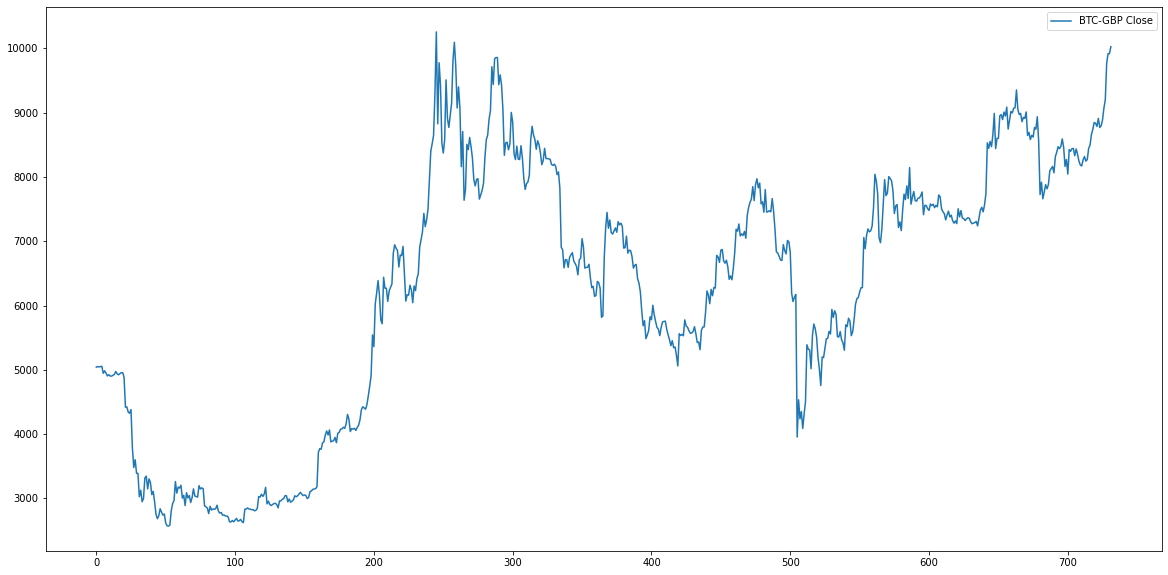

In [14]:
plt.figure(figsize = (20,10))

plt.plot(data['close'], label='BTC-GBP Close')
plt.legend()

# plot the close value which is what we intend to try and predict
plt.show()

The close price contains an awful lot of noise that will make it very difficult to learn any patterns and predict future values. Therefore several different 
statistics/transforms will be calculated to reduce the noise and smooth out the trends

In [15]:
data['close_7d_ma'] = data['close'].rolling(7).mean()

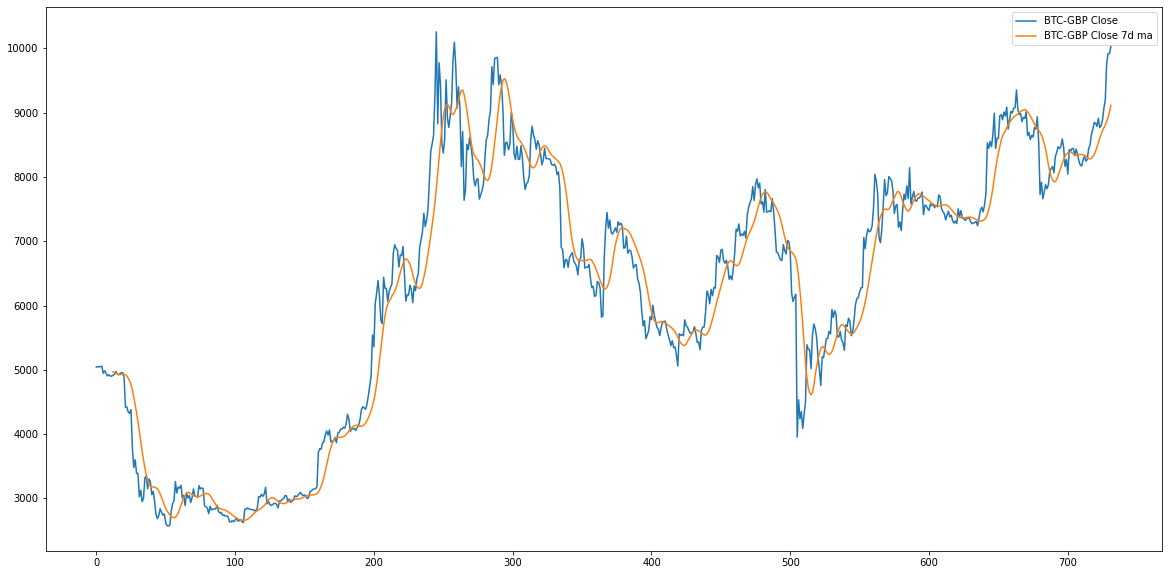

In [16]:
# plot moving average of the close value which should denoise somewhat to aid predictions
plt.figure(figsize = (20,10))
plt.plot(data['close'], label='BTC-GBP Close')
plt.plot(data['close_7d_ma'].rolling(7).mean(), label='BTC-GBP Close 7d ma')
plt.legend()
plt.show()

## Trial a wavelet transform to denoise data

In [17]:
import pywt

In [18]:
x = np.array(data.close)                
(ca, cd) = pywt.dwt(x, "haar")                
cat = pywt.threshold(ca, np.std(ca), mode="soft")                
cdt = pywt.threshold(cd, np.std(cd), mode="soft")                
data['close_wvlt'] = pywt.idwt(cat, cdt, "haar")

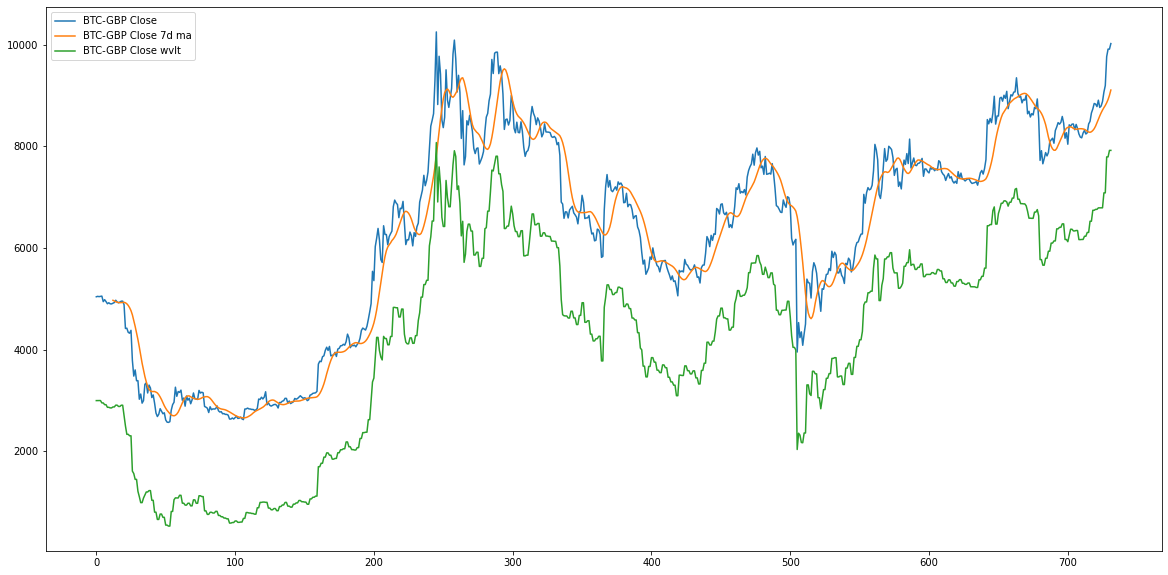

In [19]:
# additionally plot close transformed by wavelet which should denoise
plt.figure(figsize = (20,10))
plt.plot(data['close'], label='BTC-GBP Close')
plt.plot(data['close_7d_ma'].rolling(7).mean(), label='BTC-GBP Close 7d ma')
plt.plot(data['close_wvlt'], label='BTC-GBP Close wvlt')
plt.legend()
plt.show()

## EWMA - Exponentially Weighted Moving Average

In [20]:
data['close_ewma'] = data['close'].ewm(span=7).mean()

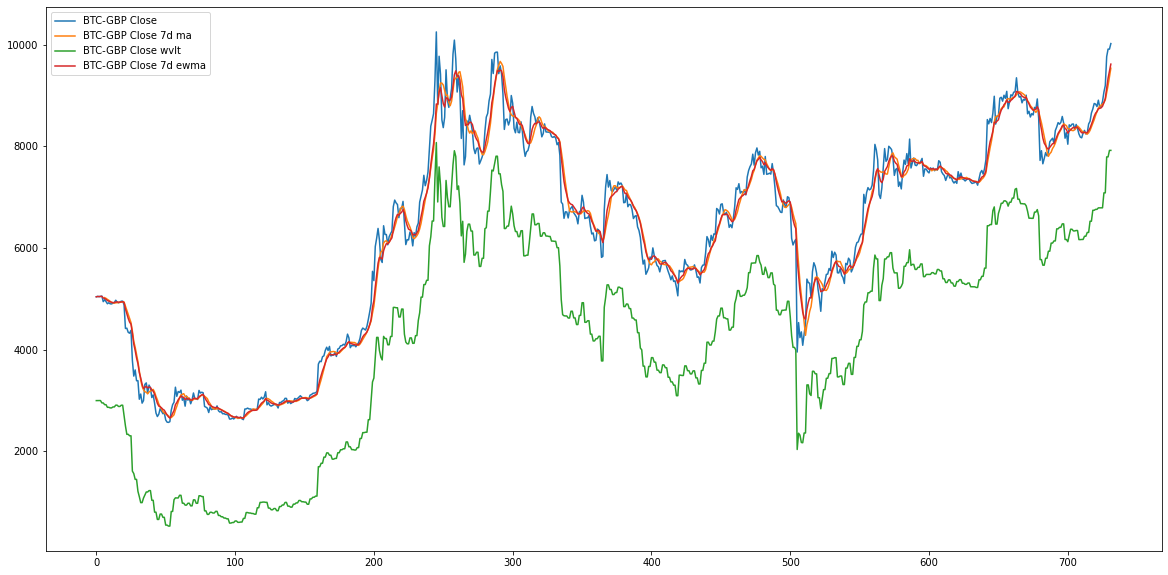

In [21]:
plt.figure(figsize = (20,10))
plt.plot(data['close'], label='BTC-GBP Close')
plt.plot(data['close_7d_ma'], label='BTC-GBP Close 7d ma')
plt.plot(data['close_wvlt'], label='BTC-GBP Close wvlt')
plt.plot(data['close_ewma'], label='BTC-GBP Close 7d ewma')
plt.legend()
plt.show()

## Percentage change

The data does not look stationary in that there appears to be an upward trend over time. Ideally we would want to increase the stationarity of this data set so  we can have a greater degree of confidence that parameters such as the mean and variance would remain consistent over time.

This can be tested using a Augmented Dickey-Fuller (ADF) Test

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
def ADF_Cal(x):
    result = adfuller(x)
    ADF_stat = result[0]
    p = result[1]
    print("ADF Statistic: %f" % ADF_stat)
    print("p-value: %f" % p)
    print("Critical Values")
    levels = [.01, .05, .1]
    i = 0
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key,value))
        hyp = p < levels[i]
        if ADF_stat < value:
            cert = (1-levels[i])*100
            print("{}% certain this is stationary".format(cert))
            print('Reject H0: {}'.format(hyp))
            break
        i = i+1
        if i >= 3:
            print("Less than 90% certain that data is stationary")
            print('Reject H0: {}'.format(hyp))

In [24]:
ADF_Cal(data.close)

ADF Statistic: -0.932842
p-value: 0.776965
Critical Values
	1%: -3.439
	5%: -2.866
	10%: -2.569
Less than 90% certain that data is stationary
Reject H0: False


The intuition appears to be correct, the data is not stationary. To address this convert prices and volume to percentage change from the prior day and apply min-max scaling so that the values fall between 0 and 1.  Perform the ADF test again to check.

In [25]:
# reset data
data = download_finance_data(['BTC-GBP'],from_date,to_date)

In [26]:
# set date
data['date'] = pd.to_datetime(data.date)

# only a single nan so ffil from previous day
data = data.fillna(method='ffill')

In [27]:
# convert actual prices to daily percentage change
data['open'] = data['open'].pct_change() 
data['high'] = data['high'].pct_change() 
data['low'] = data['low'].pct_change()
data['close'] = data['close'].pct_change()
data['volume'] = data['volume'].pct_change()

data.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

data = data.reset_index(drop=True)

min_return = min(data[['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(data[['open', 'high', 'low', 'close']].max(axis=0))

# # Min-max normalize price columns (0-1 range)
data['open'] = (data['open'] - min_return) / (max_return - min_return)
data['high'] = (data['high'] - min_return) / (max_return - min_return)
data['low'] = (data['low'] - min_return) / (max_return - min_return)
data['close'] = (data['close'] - min_return) / (max_return - min_return)

# Calculate Min/Max of price columns'

min_volume = data['volume'].min(axis=0)
max_volume = data['volume'].max(axis=0)


In [28]:
data.head()

,currency_pair,date,open,high,low,close,adj close,volume
0,BTC-GBP,2018-10-25,0.579461,0.580005,0.572412,0.568445,5050.398926,-0.052316
1,BTC-GBP,2018-10-26,0.569831,0.564309,0.575626,0.564231,5044.995605,0.022519
2,BTC-GBP,2018-10-27,0.567252,0.567184,0.564741,0.567731,5050.808105,0.026666
3,BTC-GBP,2018-10-28,0.566803,0.564460,0.564221,0.567304,5055.258789,0.015260
4,BTC-GBP,2018-10-29,0.568068,0.566743,0.535751,0.532084,4946.676758,0.221844


In [29]:
ADF_Cal(data.close)

ADF Statistic: -18.702786
p-value: 0.000000
Critical Values
	1%: -3.439
99.0% certain this is stationary
Reject H0: True


This gives us a good level of confidence in the stationarity of our data. Now to calculate moving averages as before and visualise

In [30]:
data['close_7d_ma'] = data['close'].rolling(7).mean()
data['close_ewma'] = data['close'].ewm(span=7).mean()

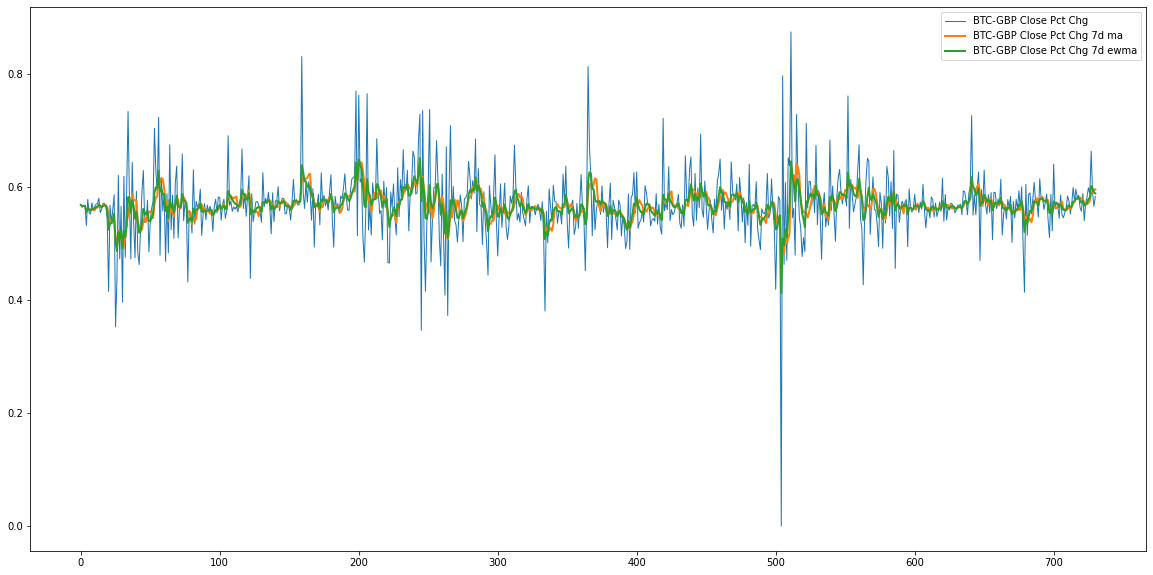

In [31]:
plt.figure(figsize = (20,10))
plt.plot(data['close'], label='BTC-GBP Close Pct Chg', linewidth = 1)
plt.plot(data['close_7d_ma'], label='BTC-GBP Close Pct Chg 7d ma', linewidth = 2)
plt.plot(data['close_ewma'], label='BTC-GBP Close Pct Chg 7d ewma', linewidth = 2)
plt.legend()
plt.show()

## Summary

A small amount of data preprocessing and cleaning is needed, the date column needs to be cast to a pandas datetime type and nan values need to be handled.

The close price that we want to predict contains a good deal of noise that will make it difficult to train an algorithm to predict. Applying a wavelet transform did not appear to denoise enough to be useful. Both moving averages did a good job of smoothing out and removing the noise.

The data did not look stationary and this was confirmed via an ADF test. Data was converted to percentage change values from the prior day and the ADF test repeated to show strong evidence that the data was now stationary. Again moving averages smoothed out and removed noise well making them good candidates to train and predict on.

A python pre-processing class will be built that will receive the finance data and perform the preprocessing and cleaning. Additionally the class will provide functions to calculate the percentage change and the different moving averages.